# Simulations 2

In these simulations, we test the effect of different capture efficiencies in the observed binarity of the data. We simulate single cell splicing with a fixed $\Psi = 0.5$ for every exon, and then simulate mRNA capture and sequencing with different captur efficiency levels $c\in\{0.01, 0.012, ..., 0.1\}$. We repeated the simulations 50 times for each capture efficiency value.

We then estimated the observed $\Psi$ for each exon in each cell. We ranked the exon by the number of reads that cover them, and estimated the fraction of binary ($\Psi = 0/1$) observations. We also estimated the deviation of the estimated $\Psi$ from the real $\Psi = 0.5$.

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from numpy import random as r

from pylab import *
from IPython.core.pylabtools import figsize

import seaborn as sns
import matplotlib.cm as cm

import sys
sys.path.insert(0, '../../utils')
import splicing_utils as spu
import single_cell_plots as scp
from single_cell_plots import *

# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

In [2]:
def process_symsim(tabla, gene_len, n=300, g=500, read_len=50):
    
    gene_len_i = gene_len[:g]
    gene_len_e = gene_len[g:]
    
    biases_i = (4*(read_len-1))/gene_len_i
    biases_e = (2*(read_len-1))/gene_len_e
    
    i = tabla.iloc[:g]
    e = tabla.iloc[g:].reset_index(drop=True)
    
    cuentas_i = pd.DataFrame(np.array([r.binomial(i.loc[x], biases_i[x]) for x in i.index]))
    cuentas_e = pd.DataFrame(np.array([r.binomial(e.loc[x], biases_e[x]) for x in e.index]))
    
    counts = cuentas_i + cuentas_e
    counts_adjusted = cuentas_i + 2*cuentas_e
    psi = cuentas_i/counts_adjusted
    
    return counts, psi#, i, e




def get_bimodal(obs_table, mrna_table, gene_len, cap):
    counts_table, psi_table = process_symsim(obs_table, gene_len)
    counts_table.columns = obs_table.columns
    psi_table.columns = obs_table.columns

    counts_table.index = ['ase_'+str(x) for x in range(1, 501)]
    psi_table.index = ['ase_'+str(x) for x in range(1, 501)]
    
    sorted_mean_expression = mrna_table.mean(axis=1).sort_values()
    sorted_ase = sorted_mean_expression.index
    
    psi_bimodal = (psi_table.loc[sorted_ase] <= 0.01) | (psi_table.loc[sorted_ase] >= 0.99)
    
    sorted_error = np.sum(psi_bimodal, axis=1) / ((~psi_table.loc[sorted_ase].isnull()).sum(axis=1))
    
#     sr_table = counts_table/((1.5)*mrna_table)
#     sorted_sr = sr_table.loc[sorted_ase]
#     drop_outs = 1-np.mean((sorted_sr >= 0.0000001))
#     drop_outs = drop_outs.mask(drop_outs).isnull().mean(axis=1)
#     sorted_sr = sorted_sr.mask(sorted_sr <= 0.0000001).mean(axis=1)
    
    return sorted_mean_expression, sorted_error#, sorted_sr#, drop_outs


def get_error(obs_table, mrna_table, gene_len):
    counts_table, psi_table = process_symsim(obs_table, gene_len)
    counts_table.columns = obs_table.columns
    psi_table.columns = obs_table.columns

    counts_table.index = ['ase_'+str(x) for x in range(1, 501)]
    psi_table.index = ['ase_'+str(x) for x in range(1, 501)]
    
    sorted_mean_expression = counts_table.mean(axis=1).sort_values()
    sorted_ase = sorted_mean_expression.index
    sorted_error = np.sum(np.abs(psi_table.loc[sorted_ase] - 0.5), axis=1) / ((~psi_table.loc[sorted_ase].isnull()).sum(axis=1))
    
    return sorted_mean_expression, sorted_error


def plot_heatmap(hm_matrix, title, xlabel, ylabel, cmap, vmin, vmax, cbar_label, plot_name):
    fig = plt.figure(figsize=(12,9))

    figure_title = title
    ax  = plt.subplot(1,1,1)

    plt.text(0.5, 1.03, figure_title,
             horizontalalignment='center',
             fontsize=28,
             transform = ax.transAxes)
    
    ax = sns.heatmap(hm_matrix, cmap=cmap, vmin=vmin, vmax=vmax, cbar_kws={'label': cbar_label})
    ax.figure.axes[-1].yaxis.label.set_size(28)


    plt.xlabel(xlabel, fontsize=28)
    plt.ylabel(ylabel, fontsize=28)

    plt.savefig(plot_name + '.svg')
    plt.savefig(plot_name + '.pdf')
    plt.savefig(plot_name + '.png')

In [3]:
# #### Run this to get simulations_capture_binary.tab
# #### Note that sim2 is empty, as it is too heavy. To get the simulation files, run sim2_capture_efficiency.R first
# r.seed(0)

# sim_dir = 'sim2/'

# hm = pd.DataFrame()
# sr = pd.DataFrame()
# do = pd.DataFrame()
# out_hm = 0
# out_sr = 0
# out_do = 0

# for sim in range(1,51):
#     sim_s = str(sim)
#     gene_len_str = sim_dir + 'gene_length.sim_' + sim_s + '.txt'
#     gene_len = np.array([int(x.rstrip()) for x in open(gene_len_str).readlines()])

#     for cap in np.arange(0.01, 0.101, step=0.002):

#         cap_s = str(round(cap, 3))

#         suffix = '.sim_' + sim_s + '_cap_' + cap_s

#         reads_table = pd.read_csv(sim_dir + 'observed_counts' + suffix + '.tab', sep='\t', 
#                           names = ['cell_'+str(x) for x in range(1, 301)])
        
#         mrna_table = pd.read_csv(sim_dir + 'true_counts' + suffix + '.tab', sep='\t', 
#                           names = ['cell_'+str(x) for x in range(1, 301)])
        
#         mrna_table = 2*mrna_table.iloc[:500]
#         mrna_table.index = ['ase_'+str(x) for x in range(1, 501)]
        
#         sorted_mean_expression, sorted_error, sorted_sr, sorted_do = get_bimodal(reads_table, mrna_table, gene_len, cap)

#         #counts_table, psi_table, sr_table = process_symsim(reads_table, mrna_tabe, gene_len)

#         hm['cap_' + cap_s] = list(sorted_error)[::-1]
#         sr['cap_' + cap_s] = list(sorted_sr)[::-1]
#         do['cap_' + cap_s] = list(sorted_do)[::-1]
#         #print(cap)
#     out_hm += hm
#     out_sr += sr
#     out_do += do
#     print(sim)
    
# out_hm = out_hm/50
# out_sr = out_sr/50 # outdated
# out_do = out_do/50 # outdated

In [16]:
# out_hm.columns = [x.split('_')[1] for x in hm.columns]
# out_hm.index = range(1,501)
# out_hm.to_csv('simulations_capture_binary.tab', sep='\t', index=True, header=True)

hm_binary = pd.read_csv('simulations_capture_binary.tab', sep='\t', index_col=0)
hm_binary = hm_binary.dropna()


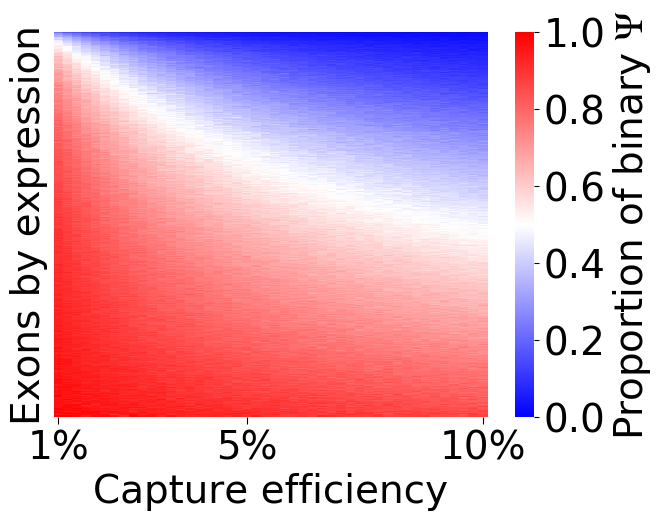

In [18]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"
# mpl.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(7,5))

ax  = plt.subplot(1,1,1)


ax = sns.heatmap(hm_binary.dropna(), cmap='bwr', vmin=0, vmax=1, 
                 cbar_kws={'label': "Proportion of binary $\Psi$",}, 
                 yticklabels=False)

# cb = plt.colorbar(ax)
# cb.set_label(label='Proportion of binary $\Psi$',size=28)
# cb.ax.tick_params(labelsize=28, length=5)
# cb.outline.set_visible(False)
ax.figure.axes[-1].yaxis.label.set_size(28)


plt.xlabel('Capture efficiency', fontsize=28)
plt.ylabel('Exons by expression', fontsize=28)

#locs, labels = plt.xticks()

# xlocs = np.array([0.5, 5.5, 10.5, 15.5, 20.5, 25.5, 30.5, 35.5, 40.5, 45.5])
# xnewLabels = np.array(['0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1'])
xlocs = np.array([0.5, 20.5,45.5])
xnewLabels = np.array(['1%', '5%', '10%'])

# xlocs = np.array([5.5, 10.5,  15.5, 25.5, 30.5, 35.5, 45.5])
# xnewLabels = np.array(['0.02', 0.03, '0.04', '0.06', 0.07, '0.08', '0.1'])
plt.xticks(xlocs, xnewLabels)


# ylocs = np.array([490.5, 399.5, 299.5, 199.5, 99.5, 0.5])
# ynewLabels = np.array(['0.01', '0.1', '0.2', '0.3', '0.4', '0.5'])
# plt.yticks(ylocs, ynewLabels)

ax.tick_params(labelsize=28)
ax.figure.axes[-1].tick_params(labelsize=28)
ax.figure.axes[-1].yaxis.label.set_size(28)

ax.xaxis.set_tick_params(length=5)
ax.yaxis.set_tick_params(length=5)

plt.xticks(rotation=None)

plt.savefig('plots/sim_capture_efficiency_binary.svg', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim_capture_efficiency_binary.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim_capture_efficiency_binary.png', bbox_inches='tight', transparent=True)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return bound(*args, **kwds)


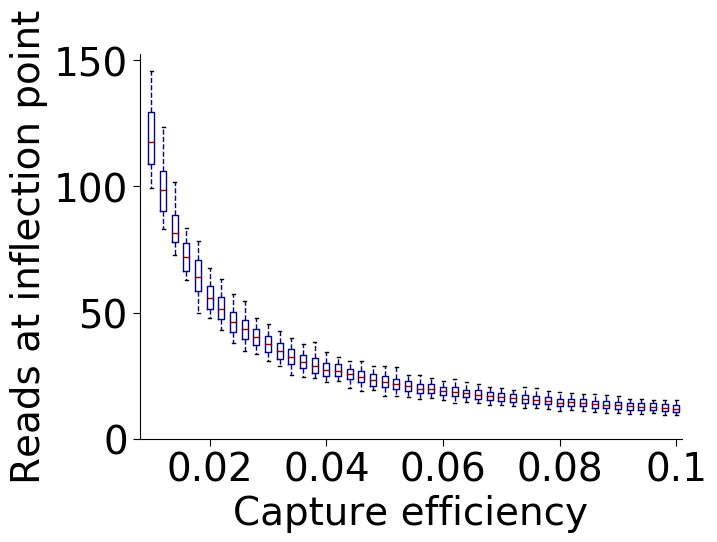

In [19]:
def get_reads(obs_table, gene_len):
    counts_table, psi_table = process_symsim(obs_table, gene_len)
    counts_table.columns = obs_table.columns
    psi_table.columns = obs_table.columns

    counts_table.index = ['ase_'+str(x) for x in range(1, 501)]
    psi_table.index = ['ase_'+str(x) for x in range(1, 501)]
    
    sorted_mean_expression = counts_table.mean(axis=1).sort_values()

    return sorted_mean_expression


# sim_dir = 'sim2/'

# hm_2 = pd.DataFrame()
# out_hm = 0

# for sim in range(1,51):
#     sim_s = str(sim)
#     gene_len_str = sim_dir + 'gene_length.sim_' + sim_s + '.txt'
#     gene_len = np.array([int(x.rstrip()) for x in open(gene_len_str).readlines()])

#     cap  = 0.01
    
#     cap_s = str(round(cap, 3))

#     suffix = '.sim_' + sim_s + '_cap_' + cap_s

#     table = pd.read_csv(sim_dir + 'observed_counts' + suffix + '.tab', sep='\t', 
#                       names = ['cell_'+str(x) for x in range(1, 301)])

#     sorted_mean_expression = get_reads(table, gene_len)

#     hm_2['sim_' + sim_s] = list(sorted_mean_expression)#[::-1]
#     #out_hm += hm_2
#     print(sim)
    
#out_hm = out_hm/50
# out_hm.columns = [x.split('_')[1] for x in hm.columns]
# out_hm.index = range(1,501)
# out_hm.to_csv('simulations_capture_reads.tab', sep='\t', index=True, header=True)

hm_reads = pd.read_csv('simulations_capture_reads.tab', sep='\t', index_col=0)

cap_df = pd.DataFrame()
for cap in np.arange(0.01, 0.101, step=0.002):
    cap_s = str(round(cap, 3))
    
    cap_reads = list(hm_reads.loc[hm_binary.loc[np.abs(hm_binary[cap_s] - 0.5) <= 0.05][cap_s].index, [cap_s]][cap_s])
    
    cdf = pd.DataFrame({cap_s:cap_reads})
    
    cap_df = pd.concat([cap_df, cdf], ignore_index=True, axis=1)
    

cap_df.columns = [str(round(x,3)) for x in np.arange(0.01, 0.101, step=0.002)]


# import importlib
# importlib.reload(scp)
# importlib.reload(spu)
# sns.reset_orig()
# mpl.rcParams["mathtext.fontset"] = "stix"

fig = plt.figure(figsize=(7,5))


ax  = plt.subplot(1,1,1)

bp = ax.boxplot([cap_df[x].dropna() for x in cap_df.columns])
    
plt.setp(bp['boxes'], color='darkblue')
plt.setp(bp['whiskers'], color='darkblue', linestyle='--')
plt.setp(bp['caps'], color='black')
plt.setp(bp['medians'], color='darkred')

plt.xlabel('Capture efficiency')
plt.ylabel('Reads at inflection point')
#ax.title('SJ reads needed for 50% unimodality')

ax.tick_params(labelsize=28)
ax.figure.axes[-1].tick_params(labelsize=28)
ax.figure.axes[-1].yaxis.label.set_size(28)
ax.figure.axes[-1].xaxis.label.set_size(28)

ax.xaxis.set_tick_params(length=5)
ax.yaxis.set_tick_params(length=5)

plt.xticks(rotation=None)


xlocs = np.array([6, 16, 26, 36, 46])
xnewLabels = np.array(['0.02', '0.04', '0.06', '0.08', '0.1'])
# xlocs = np.array([5.5, 15.5, 25.5, 35.5, 45.5])
# xnewLabels = np.array(['0.02', '0.04', '0.06', '0.08', '0.1'])
plt.xticks(xlocs, xnewLabels)
plt.yticks([0, 50, 100, 150], ['0', '50', '100', '150'])


ax.tick_params(labelsize=28)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlim((0,46.5))
# ax.spines['left'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)

# ax.xaxis.set_tick_params(width=2)
# ax.yaxis.set_tick_params(width=2)

plt.savefig('plots/sim_capture_reads_boxplot.svg', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim_capture_reads_boxplot.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim_capture_reads_boxplot.png', bbox_inches='tight', transparent=True)

In [20]:
# #### Run this to get simulations_capture_binary.tab
# #### Note that sim2 is empty, as it is too heavy. To get the simulation files, run sim2_capture_efficiency.R first
# r.seed(0)

# sim_dir = 'sim2_extended/'

# hm = pd.DataFrame()
# # sr = pd.DataFrame()
# # do = pd.DataFrame()
# out_hm = 0
# # out_sr = 0
# # out_do = 0

# for sim in tqdm(range(1,51), position=0, leave=True):
    
#     sim_s = str(sim)
#     gene_len_str = sim_dir + 'gene_length.sim_' + sim_s + '.txt'
#     gene_len = np.array([int(x.rstrip()) for x in open(gene_len_str).readlines()])

#     for cap in np.arange(0.01, 0.251, step=0.01):

#         cap_s = str(round(cap, 3))

#         suffix = '.sim_' + sim_s + '_cap_' + cap_s

#         reads_table = pd.read_csv(sim_dir + 'observed_counts' + suffix + '.tab', sep='\t', 
#                           names = ['cell_'+str(x) for x in range(1, 301)])
        
#         mrna_table = pd.read_csv(sim_dir + 'true_counts' + suffix + '.tab', sep='\t', 
#                           names = ['cell_'+str(x) for x in range(1, 301)])
        
#         mrna_table = 2*mrna_table.iloc[:500]
#         mrna_table.index = ['ase_'+str(x) for x in range(1, 501)]
        
#         sorted_mean_expression, sorted_error = get_bimodal(reads_table, mrna_table, gene_len, cap)

#         #counts_table, psi_table, sr_table = process_symsim(reads_table, mrna_tabe, gene_len)

#         hm['cap_' + cap_s] = list(sorted_error)[::-1]
# #         sr['cap_' + cap_s] = list(sorted_sr)[::-1]
# #         do['cap_' + cap_s] = list(sorted_do)[::-1]
#         #print(cap)
#     out_hm += hm
# #     out_sr += sr
# #     out_do += do
# #     print(sim)
    
# out_hm = out_hm/50
# # out_sr = out_sr/47 # outdated
# # out_do = out_do/47 # outdated

# out_hm.columns = [x.split('_')[1] for x in hm.columns]
# out_hm.index = range(1,501)
# out_hm.to_csv('simulations_capture_binary_extended.tab', sep='\t', index=True, header=True)

hm_binary = pd.read_csv('simulations_capture_binary_extended.tab', sep='\t', index_col=0)
hm_binary = hm_binary.dropna()

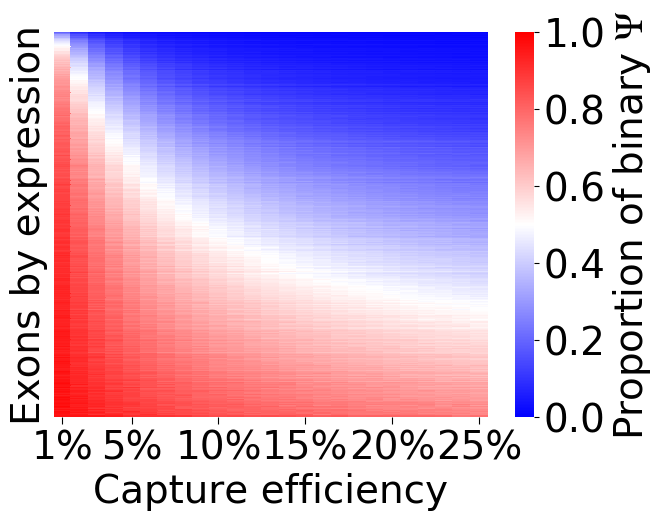

In [21]:
# import importlib
# importlib.reload(scp)
# importlib.reload(spu)
# sns.reset_orig()
# mpl.rcParams["mathtext.fontset"] = "stix"

fig = plt.figure(figsize=(7,5))

ax  = plt.subplot(1,1,1)


ax = sns.heatmap(hm_binary.dropna(), cmap='bwr', vmin=0, vmax=1, 
                 cbar_kws={'label': "Proportion of binary $\Psi$",}, 
                 yticklabels=False)

# cb = plt.colorbar(ax)
# cb.set_label(label='Proportion of binary $\Psi$',size=28)
# cb.ax.tick_params(labelsize=28, length=5)
# cb.outline.set_visible(False)
ax.figure.axes[-1].yaxis.label.set_size(28)


plt.xlabel('Capture efficiency', fontsize=28)
plt.ylabel('Exons by expression', fontsize=28)

#locs, labels = plt.xticks()


####################
# xlocs = np.array([0.5, 5.5, 10.5, 15.5, 20.5, 25.5, 30.5, 35.5, 40.5, 45.5])
# xnewLabels = np.array(['0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1'])
#######################


xlocs = np.array([0.5, 4.5,9.5, 14.5, 19.5, 24.5])
xnewLabels = np.array(['1%', '5%', '10%', '15%', '20%', '25%'])

# xlocs = np.array([5.5, 10.5,  15.5, 25.5, 30.5, 35.5, 45.5])
# xnewLabels = np.array(['0.02', 0.03, '0.04', '0.06', 0.07, '0.08', '0.1'])
plt.xticks(xlocs, xnewLabels)


# ylocs = np.array([490.5, 399.5, 299.5, 199.5, 99.5, 0.5])
# ynewLabels = np.array(['0.01', '0.1', '0.2', '0.3', '0.4', '0.5'])
# plt.yticks(ylocs, ynewLabels)

ax.tick_params(labelsize=28)
ax.figure.axes[-1].tick_params(labelsize=28)
ax.figure.axes[-1].yaxis.label.set_size(28)

ax.xaxis.set_tick_params(length=5)
ax.yaxis.set_tick_params(length=5)

plt.xticks(rotation=None)

plt.savefig('plots/sim_capture_efficiency_binary_extended.svg', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim_capture_efficiency_binary_extended.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim_capture_efficiency_binary_extended.png', bbox_inches='tight', transparent=True)

In [22]:
def get_reads(obs_table, gene_len):
    counts_table, psi_table = process_symsim(obs_table, gene_len)
    counts_table.columns = obs_table.columns
    psi_table.columns = obs_table.columns

    counts_table.index = ['ase_'+str(x) for x in range(1, 501)]
    psi_table.index = ['ase_'+str(x) for x in range(1, 501)]
    
    sorted_mean_expression = counts_table.mean(axis=1).sort_values()

    return sorted_mean_expression


# sim_dir = 'sim2_extended/'


# out_hm = 0

# for sim in tqdm(range(1,51), position=0, leave=True):
#     sim_s = str(sim)
#     gene_len_str = sim_dir + 'gene_length.sim_' + sim_s + '.txt'
#     gene_len = np.array([int(x.rstrip()) for x in open(gene_len_str).readlines()])

#     hm_2 = pd.DataFrame()
    
#     for cap in np.arange(0.01, 0.251, step=0.01):
    
#         cap_s = str(round(cap, 3))

#         suffix = '.sim_' + sim_s + '_cap_' + cap_s

#         table = pd.read_csv(sim_dir + 'observed_counts' + suffix + '.tab', sep='\t', 
#                           names = ['cell_'+str(x) for x in range(1, 301)])

#         sorted_mean_expression = get_reads(table, gene_len)

#         hm_2[cap_s] = list(sorted_mean_expression)[::-1]
        
#     out_hm += hm_2
# #     print(out_hm.head())
# #     print(sim)
    
# out_hm = out_hm/50

# # out_hm.columns = [x.split('_')[1] for x in hm_binary.columns]
# out_hm.index = range(1,501)
# out_hm.to_csv('simulations_capture_reads_extended.tab', sep='\t', index=True, header=True)

hm_reads = pd.read_csv('simulations_capture_reads_extended.tab', sep='\t', index_col=0)

hm_binary = pd.read_csv('simulations_capture_binary_extended.tab', sep='\t', index_col=0)
hm_binary = hm_binary.dropna()

In [23]:
cap_df = pd.DataFrame()
for cap in np.arange(0.01, 0.251, step=0.01):
    cap_s = str(round(cap, 3))
    
    cap_reads = list(hm_reads.loc[hm_binary.loc[np.abs(hm_binary[cap_s] - 0.5) <= 0.05][cap_s].index, [cap_s]][cap_s])
    
    cdf = pd.DataFrame({cap_s:cap_reads})
    
    cap_df = pd.concat([cap_df, cdf], ignore_index=True, axis=1)
    

cap_df.columns = [str(round(x,3)) for x in np.arange(0.01, 0.251, step=0.01)]

/home/cfbuenabadn/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/cfbuenabadn/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/cfbuenabadn/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/cfbuenabadn/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/cfbuenabadn/anaconda3/lib/python3.6/_collections_abc.py:841: Matpl

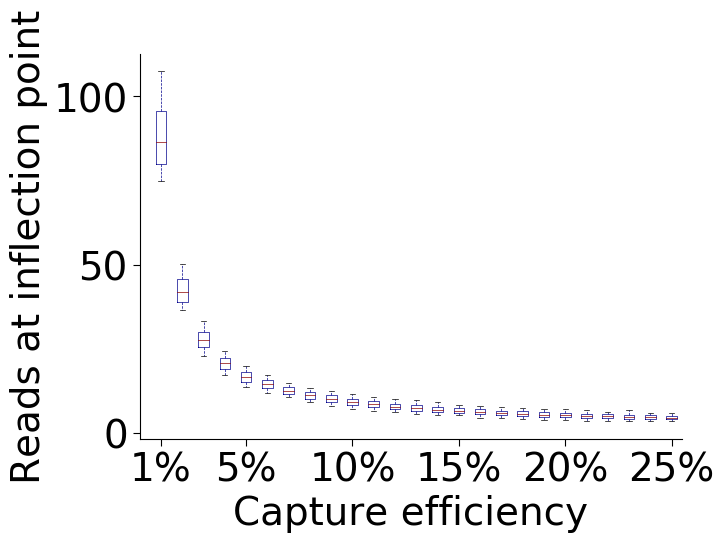

In [40]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(7,5))


ax  = plt.subplot(1,1,1)

bp = ax.boxplot([cap_df[x].dropna() for x in cap_df.columns])
    
plt.setp(bp['boxes'], color='darkblue', linewidth=0.5)
plt.setp(bp['whiskers'], color='darkblue', linestyle='--', linewidth=0.5)
plt.setp(bp['caps'], color='black', linewidth=0.5)
plt.setp(bp['medians'], color='darkred', linewidth=0.5)

plt.xlabel('Capture efficiency')
plt.ylabel('Reads at inflection point')
#ax.title('SJ reads needed for 50% unimodality')

ax.tick_params(labelsize=28)
ax.figure.axes[-1].tick_params(labelsize=28)
ax.figure.axes[-1].yaxis.label.set_size(28)
ax.figure.axes[-1].xaxis.label.set_size(28)

ax.xaxis.set_tick_params(length=5)
ax.yaxis.set_tick_params(length=5)

plt.xticks(rotation=None)


# xlocs = np.array([6, 16, 26, 36, 46])
# xnewLabels = np.array(['0.02', '0.04', '0.06', '0.08', '0.1'])
xlocs = np.array([1, 5, 10, 15, 20, 25])
xnewLabels = np.array(['1%', '5%', '10%', '15%', '20%', '25%'])
plt.xticks(xlocs, xnewLabels)
# plt.yticks([0, 50, 100, 150], ['0', '50', '100', '150'])


ax.tick_params(labelsize=28)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlim((0,25.5))
# ax.spines['left'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)

# ax.xaxis.set_tick_params(width=2)
# ax.yaxis.set_tick_params(width=2)

plt.savefig('plots/sim_capture_reads_boxplot_extended.svg', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim_capture_reads_boxplot_extended.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim_capture_reads_boxplot_extended.png', bbox_inches='tight', transparent=True)

# mRNA counts and underlying $\Psi$

In [33]:
# #### Run this to get simulations_mRNA_Psi_binary.tab
# #### Note that sim3 is empty, as it is too heavy. To get the simulation files, run sim3_mRNA_Psi.R first

# sim_dir = 'sim3'
# old_tab = 0
# for sim in range(1, 51):
#     #plt.figure()
#     bimodal_tab = pd.DataFrame()
#     sim_s = str(sim)
#     for psi in np.arange(0.05, 0.51, 0.01):
#         psi_s = str(round(psi, 2))
        
#         gene_len_str = sim_dir + 'gene_length.psi_' +psi_s + '_sim_'+str(sim)+'.txt'

#         gene_len = np.array([int(x.rstrip()) for x in open(gene_len_str).readlines()])

#         tab_name = sim_dir + 'observed_counts.psi_{psi}_sim_{sim}.tab'.format(psi=psi_s, sim=sim_s)
        
#         table = pd.read_csv(tab_name, sep='\t', 
#                           names = ['cell_'+str(x) for x in range(1, 301)])
        
#         counts_table, psi_table = process_symsim(table, gene_len)
#         bimodal_list = np.sum((psi_table == 0) | (psi_table==1), axis=1) / (~psi_table.isnull()).sum(axis=1)
#         bimodal_tab['psi_' + psi_s] = bimodal_list
#         #print('psi: ' + psi_s)
#     #sns.heatmap(error_tab, cmap=cm.bwr)
#     #plt.show()
#     old_tab = old_tab + bimodal_tab
#     print('sim: ' + str(sim))
    
# hm = old_tab/50
    
# hm.to_csv('simulations_mRNA_Psi_binary.tab', sep='\t', index=True, header=True)

hm_binary = pd.read_csv('simulations_mRNA_Psi_binary.tab', sep='\t', index_col=0)

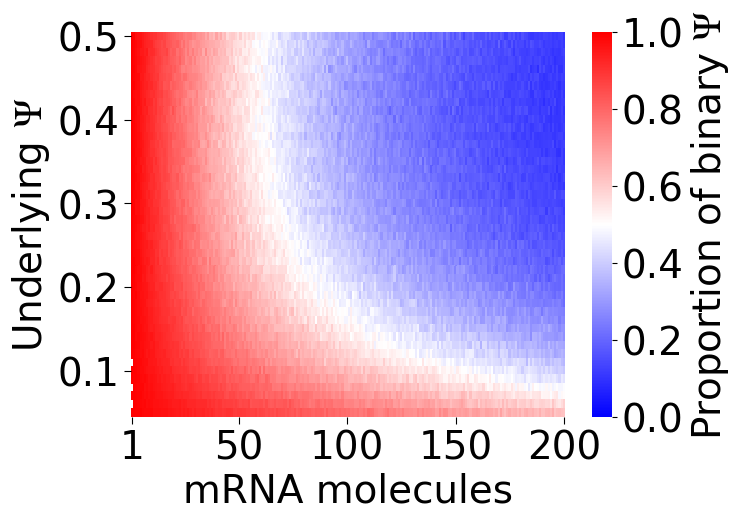

In [26]:
# import importlib
# importlib.reload(scp)
# importlib.reload(spu)
# sns.reset_orig()
# mpl.rcParams["mathtext.fontset"] = "stix"

fig = plt.figure(figsize=(7,5))

ax  = plt.subplot(1,1,1)


ax = sns.heatmap(hm_binary.loc[hm_binary.index[:200],hm_binary.columns[::-1]].T, cmap='bwr', vmin=0, vmax=1, 
                 cbar_kws={'label': r"Proportion of binary $\Psi$",})
ax.figure.axes[-1].yaxis.label.set_size(28)


plt.xlabel('mRNA molecules', fontsize=28)
plt.ylabel('Underlying $\Psi$', fontsize=28)

#locs, labels = plt.xticks()

xlocs = np.array([0.5, 49.5, 99.5, 149.5, 199.5])
xnewLabels = np.array(['1', '50', '100', '150', '200'])
plt.xticks(xlocs, xnewLabels)


# ylocs = np.array([45.5, 40.5, 35.5, 30.5, 25.5, 20.5, 15.5, 10.5, 5.5, 0.5])
# ynewLabels = np.array(['0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4', '0.45', '0.5'])
ylocs = np.array([40.5, 30.5, 20.5, 10.5, 0.5])
ynewLabels = np.array(['0.1', '0.2', '0.3', '0.4', '0.5'])
plt.yticks(ylocs, ynewLabels)


# ylocs = np.array([490.5, 399.5, 299.5, 199.5, 99.5, 0.5])
# ynewLabels = np.array(['0.01', '0.1', '0.2', '0.3', '0.4', '0.5'])
# plt.yticks(ylocs, ynewLabels)

ax.tick_params(labelsize=28)
ax.figure.axes[-1].tick_params(labelsize=28)
ax.figure.axes[-1].yaxis.label.set_size(28)

ax.xaxis.set_tick_params(length=5)
ax.yaxis.set_tick_params(length=5)

plt.xticks(rotation=None)

plt.savefig('plots/sim3_expression_v_psi_binary.svg', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim3_expression_v_psi_binary.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim3_expression_v_psi_binary.png', bbox_inches='tight', transparent=True)

In [29]:
mrna_list = []
psi_list = []
for psi in hm_binary.columns:
    sim_slice = hm_binary.loc[hm_binary.index[:200],hm_binary.columns[::-1]].T.loc[psi]
    mrna_n = sim_slice.loc[(sim_slice <= 0.55) & (sim_slice >= 0.45)].index/10
    if len(mrna_n) > 1:
        mrna_list.append(list(mrna_n))
        psi_list.append(psi)

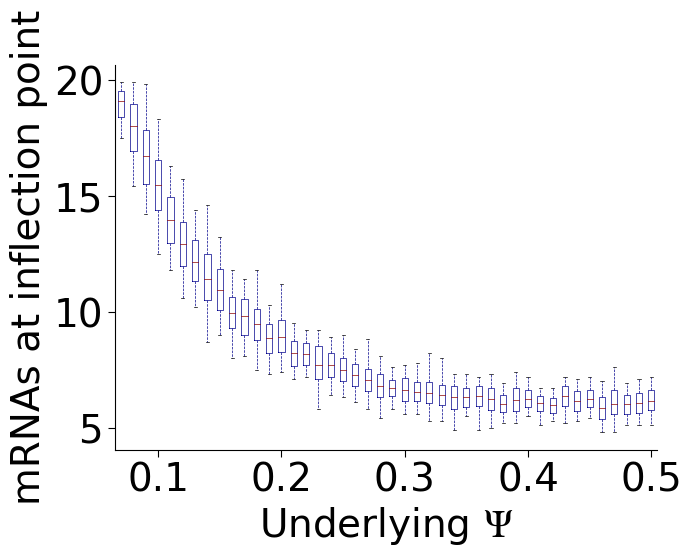

In [41]:
# import importlib
# importlib.reload(scp)
# importlib.reload(spu)
# sns.reset_orig()
# mpl.rcParams["mathtext.fontset"] = "stix"

fig = plt.figure(figsize=(7,5))


ax  = plt.subplot(1,1,1)

bp = ax.boxplot(mrna_list, showfliers=False)
    
plt.setp(bp['boxes'], color='darkblue', linewidth=0.5)
plt.setp(bp['whiskers'], color='darkblue', linestyle='--', linewidth=0.5)
plt.setp(bp['caps'], color='black', linewidth=0.5)
plt.setp(bp['medians'], color='darkred', linewidth=0.5)

plt.xlabel('Underlying $\Psi$')
plt.ylabel('mRNAs at inflection point')
#ax.title('SJ reads needed for 50% unimodality')

ax.tick_params(labelsize=28)
ax.figure.axes[-1].tick_params(labelsize=28)
ax.figure.axes[-1].yaxis.label.set_size(28)
ax.figure.axes[-1].xaxis.label.set_size(28)

ax.xaxis.set_tick_params(length=5)
ax.yaxis.set_tick_params(length=5)

plt.xticks(rotation=None)


# xlocs = np.array([6, 16, 26, 36, 46])
# xnewLabels = np.array(['0.02', '0.04', '0.06', '0.08', '0.1'])
xlocs = np.array([4, 14, 24, 34, 44])
xnewLabels = np.array(['0.1', '0.2', '0.3', '0.4', '0.5'])
plt.xticks(xlocs, xnewLabels)
# plt.yticks([0, 50, 100, 150], ['0', '50', '100', '150'])


ax.tick_params(labelsize=28)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# ax.set_xlim((0,25.5))
# ax.spines['left'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)

# ax.xaxis.set_tick_params(width=2)
# ax.yaxis.set_tick_params(width=2)

plt.savefig('plots/mrna_for_50.svg', bbox_inches='tight', transparent=True)
plt.savefig('plots/mrna_for_50.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots/mrna_for_50.png', bbox_inches='tight', transparent=True)

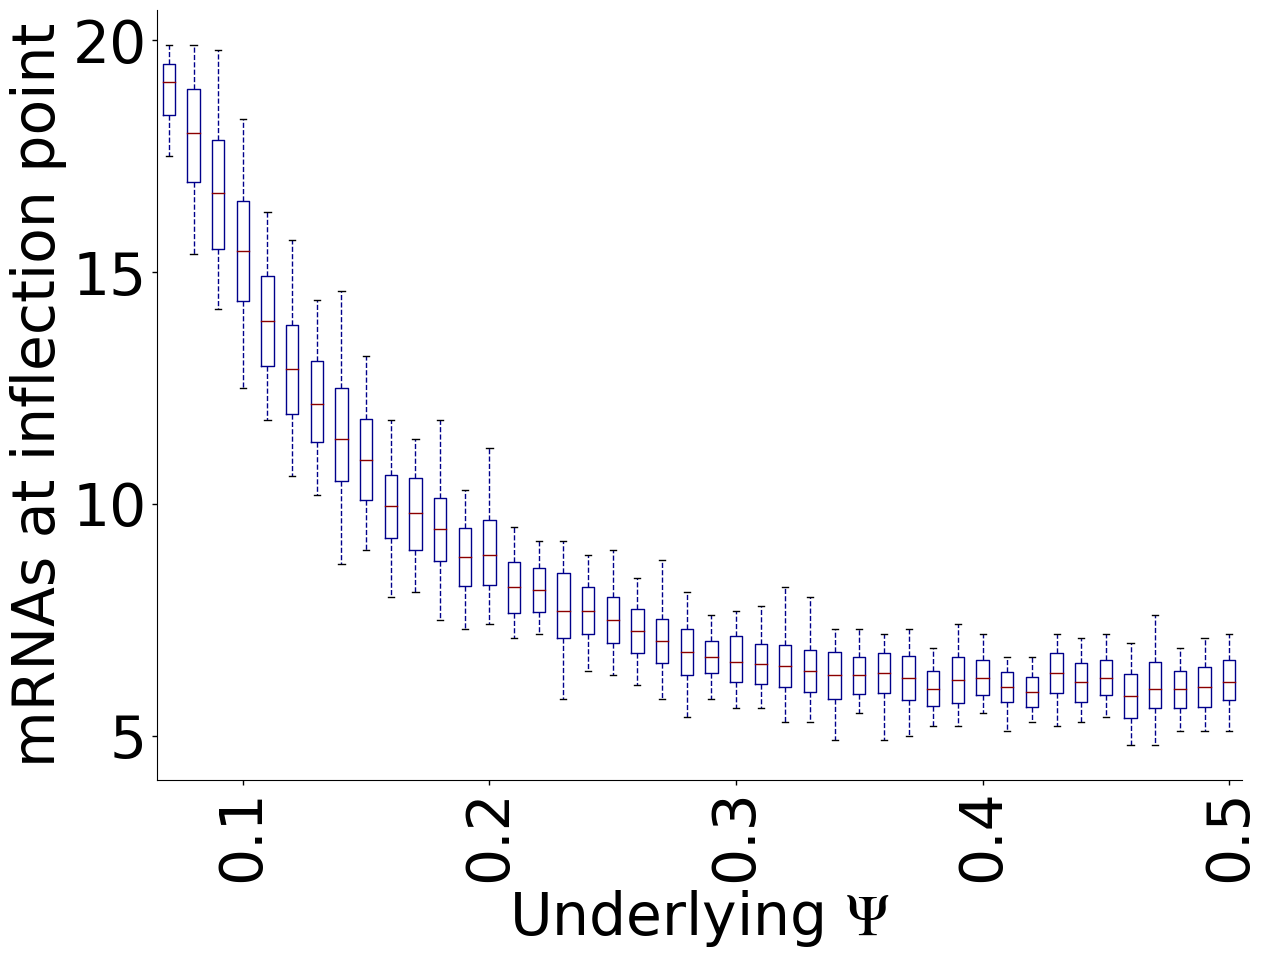

In [30]:
scp.plot_boxplot(mrna_list, 'mRNAs at inflection point', 
             ['0.1', '0.2', '0.3', '0.4', '0.5'], 'mrna_for_50', xlocs = [4, 14, 24, 34, 44],ylocs=[5, 10, 15, 20],
                 ytags=['5', '10', '15', '20'],
                 xlabel='Underlying $\Psi$',save_dir='plots/', plot_line = False)

# Amplification and PCR cycles

In [18]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

# #### Run this to get simulations_mRNA_Psi_binary.tab
# #### Note that sim4 is empty, as it is too heavy. To get the simulation files, run sim4_amplification.R first

# sim_dir = 'sim4'

# out_hm = 0
# out_hm_bimodal = 0

# for sim in range(1,51):
    
#     sim_s = str(sim)
    
#     hm = pd.DataFrame()
#     hm_bim = pd.DataFrame()

#     for amp in np.arange(0.5, 0.96, step=0.01):

#         amp_s = str(round(amp, 2))

#         amp_error = []
#         amp_bim = []

#         for pcr1 in range(10, 26):

#             pcr1_s = str(pcr1)
            
#             gene_len_name = sim_dir + 'gene_length.sim_' + sim_s + '.txt'

#             gene_len = np.array([int(x.rstrip()) for x in open(gene_len_name).readlines()])

#             suffix = '.sim_' + sim_s + '_pcr1_' + pcr1_s + '_amp_' + amp_s

#             table = pd.read_csv(sim_dir + 'observed_counts' + suffix + '.tab', sep='\t', 
#                               names = ['cell_'+str(x) for x in range(1, 301)])

#             sorted_mean_expression, sorted_error = get_error(table, gene_len)
#             sorted_mean_expression_bim, sorted_bim = get_error(table, gene_len)

#             pcr_error = sorted_error.mean()
#             pcr_bim = sorted_bim.mean()
            
#             amp_error.append(pcr_error)
#             amp_bim.append(pcr_bim)


#         hm['amp_' + amp_s] = amp_error
#         hm_bim['amp_' + amp_s] = amp_bim
        
#     print(sim)
        
#     out_hm += hm
#     out_hm_bimodal += hm_bim

# out_hm = out_hm/50
# out_hm_bimodal = out_hm_bimodal/50

# out_hm_bimodal.to_csv('simulations_amplification_binary.tab', sep='\t', index=True, header=True)

hm_binary = pd.read_csv('simulations_amplification.tab', sep='\t', index_col=0)


/home/cfbuenabadn/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/cfbuenabadn/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/cfbuenabadn/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/cfbuenabadn/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/cfbuenabadn/anaconda3/lib/python3.6/_collections_abc.py:841: Matpl

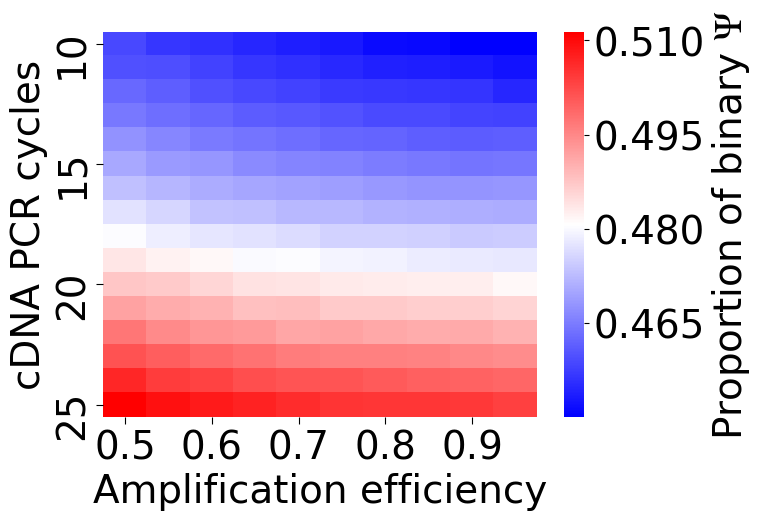

In [19]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"

fig = plt.figure(figsize=(7,5))

ax  = plt.subplot(1,1,1)


ax = sns.heatmap(hm_binary, cmap='bwr',
                 cbar_kws={'label': "Proportion of binary $\Psi$",}, 
                 xticklabels=99)
ax.figure.axes[-1].yaxis.label.set_size(28)


plt.xlabel('Amplification efficiency', fontsize=28)
plt.ylabel('cDNA PCR cycles', fontsize=28)

#locs, labels = plt.xticks()

xlocs = np.array([0.5, 2.5, 4.5, 6.5, 8.5])
xnewLabels = np.array(['0.5', '0.6', '0.7', '0.8', '0.9'])
plt.xticks(xlocs, xnewLabels)


ylocs = np.array([15.5, 10.5, 5.5, 0.5])
ynewLabels = np.array(['25', '20', '15', '10'])
plt.yticks(ylocs, ynewLabels)

ax.tick_params(labelsize=28)
ax.figure.axes[-1].tick_params(labelsize=28)
ax.figure.axes[-1].yaxis.label.set_size(28)

ax.xaxis.set_tick_params(length=5)
ax.yaxis.set_tick_params(length=5)


plt.savefig('plots/sim_cDNA_amp_binary.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim_cDNA_amp_binary.svg', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim_cDNA_amp_binary.png', bbox_inches='tight', transparent=True)

### cDNA vs fragment amplification

In [20]:
# #### Run this to get simulations_cDNA_fragment_binary.tab
# #### Note that sim5 is empty, as it is too heavy. To get the simulation files, run sim5_simulations_cDNA_fragment.R first

# sim_dir = 'sim5/'
# hm_out = 0
# hm_out_bin = 0

# for sim in range(1, 51):
    
#     hm = pd.DataFrame()
#     hm_bin = pd.DataFrame()
    
#     sim_s = str(sim)

#     for pcr1 in range(10, 26):

        

#         pcr1_s = str(pcr1)

#         cap_error = []
#         cap_bin = []

#         for pcr2 in range(5, 16):

#             pcr2_s = str(pcr2)

#             gene_len = np.array([int(x.rstrip()) for x in open(sim_dir + 'gene_length.sim_'+sim_s+'.txt').readlines()])

            
#             suffix = '.sim_1_pcr1_' + pcr1_s + '_pcr2_' + pcr2_s
#             table = pd.read_csv(sim_dir + 'observed_counts' + suffix + '.tab', sep='\t', 
#                               names = ['cell_'+str(x) for x in range(1, 301)])

#             sorted_mean_expression, sorted_error = get_error(table, gene_len)
#             sorted_mean_expression_bin, sorted_bin = get_bimodal(table, gene_len)

#             pcr_error = sorted_error.mean()
#             cap_error.append(pcr_error)
            
#             pcr_bin = sorted_bin.mean()
#             cap_bin.append(pcr_bin)


#         hm[pcr1_s] = cap_error
#         hm_bin[pcr1_s] = cap_bin
#         #print(pcr1_s)
        
#     hm_out += hm
#     hm_out_bin += hm_bin
#     print(sim)
    
# hm_out = hm_out/50
# hm_out_bin = hm_out_bin/50
        
# hm_out_bin.to_csv('simulations_cDNA_fragment_binary.tab', sep='\t', index=True, header=True)
    
hm_binary = pd.read_csv('simulations_cDNA_fragment_binary.tab', sep='\t', index_col=0)



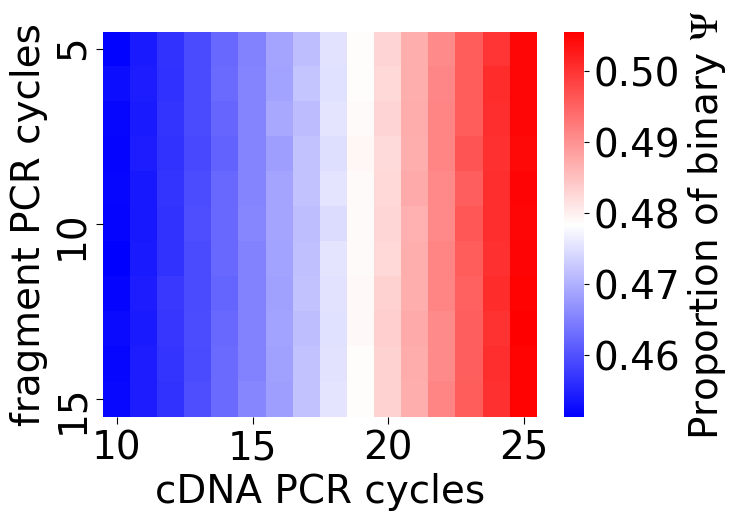

In [21]:
#hm_.index = range(1,201)
#sns.heatmap(hm_[hm_.columns[::-1]].T, cmapfig = plt.figure(figsize=(12,9)))

#figure_title = "Likelihood of $\Psi$ binary observations"
fig = plt.figure(figsize=(7,5))

ax  = plt.subplot(1,1,1)


ax = sns.heatmap(hm_binary, cmap='bwr',
                 cbar_kws={'label': "Proportion of binary $\Psi$",}, 
                 xticklabels=99)
ax.figure.axes[-1].yaxis.label.set_size(28)


plt.xlabel('cDNA PCR cycles', fontsize=28)
plt.ylabel('fragment PCR cycles', fontsize=28)

#locs, labels = plt.xticks()

xlocs = np.array([0.5, 5.5, 10.5, 15.5])
xnewLabels = np.array(['10', '15', '20', '25'])
plt.xticks(xlocs, xnewLabels)


ylocs = np.array([10.5, 5.5, 0.5])
ynewLabels = np.array(['15', '10', '5'])
plt.yticks(ylocs, ynewLabels)

ax.tick_params(labelsize=28)
ax.figure.axes[-1].tick_params(labelsize=28)
ax.figure.axes[-1].yaxis.label.set_size(28)

ax.xaxis.set_tick_params(length=5)
ax.yaxis.set_tick_params(length=5)


plt.savefig('plots/sim_cDNA_fragment_binary.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim_cDNA_fragment_binary.svg', bbox_inches='tight', transparent=True)
plt.savefig('plots/sim_cDNA_fragment_binary.png', bbox_inches='tight', transparent=True)